Dataset downloaded successfully! an outdated `kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.11).

Initial shape: (170653, 19)ully! an outdated `kagglehub` version (installed: 0.3.7), please consider upgrading to the latest version (0.3.11).



=== PERFORMANCE OPTIMIZATION STRATEGY ===
The original SVM implementation is too slow because:
- SVMs scale poorly with dataset size (complexity between O(n²) and O(n³))
- The Spotify dataset is very large (>100k samples)
- RBF kernel is computationally intensive
- GridSearchCV with n_jobs=-1 can cause overhead

Optimizations applied:
1. Sampling the dataset to a manageable size
2. Comparing multiple SVM implementations (SVC, LinearSVC, SGDClassifier)
3. Using a more extensive hyperparameter search
4. Setting reasonable time limits and iterations
=== END STRATEGY ===

After dropping missing values: (170653, 19)
Working with sampled dataset: (10000, 20) samples
Class distribution in sampled data: popul

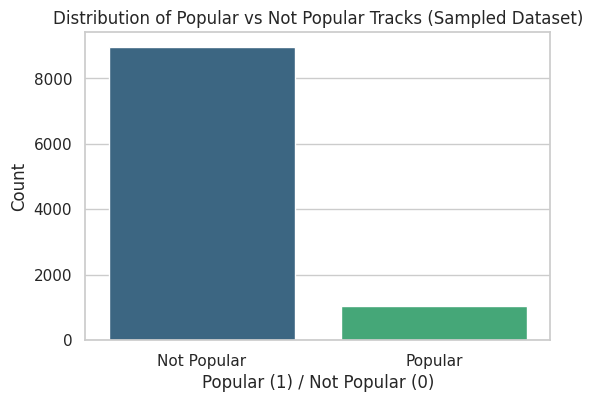

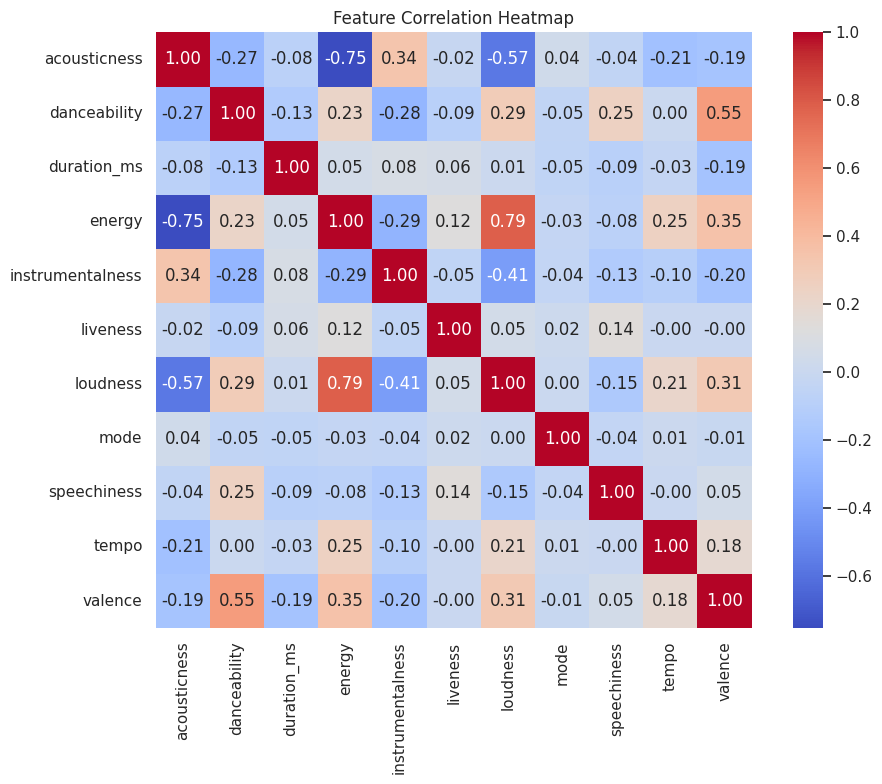

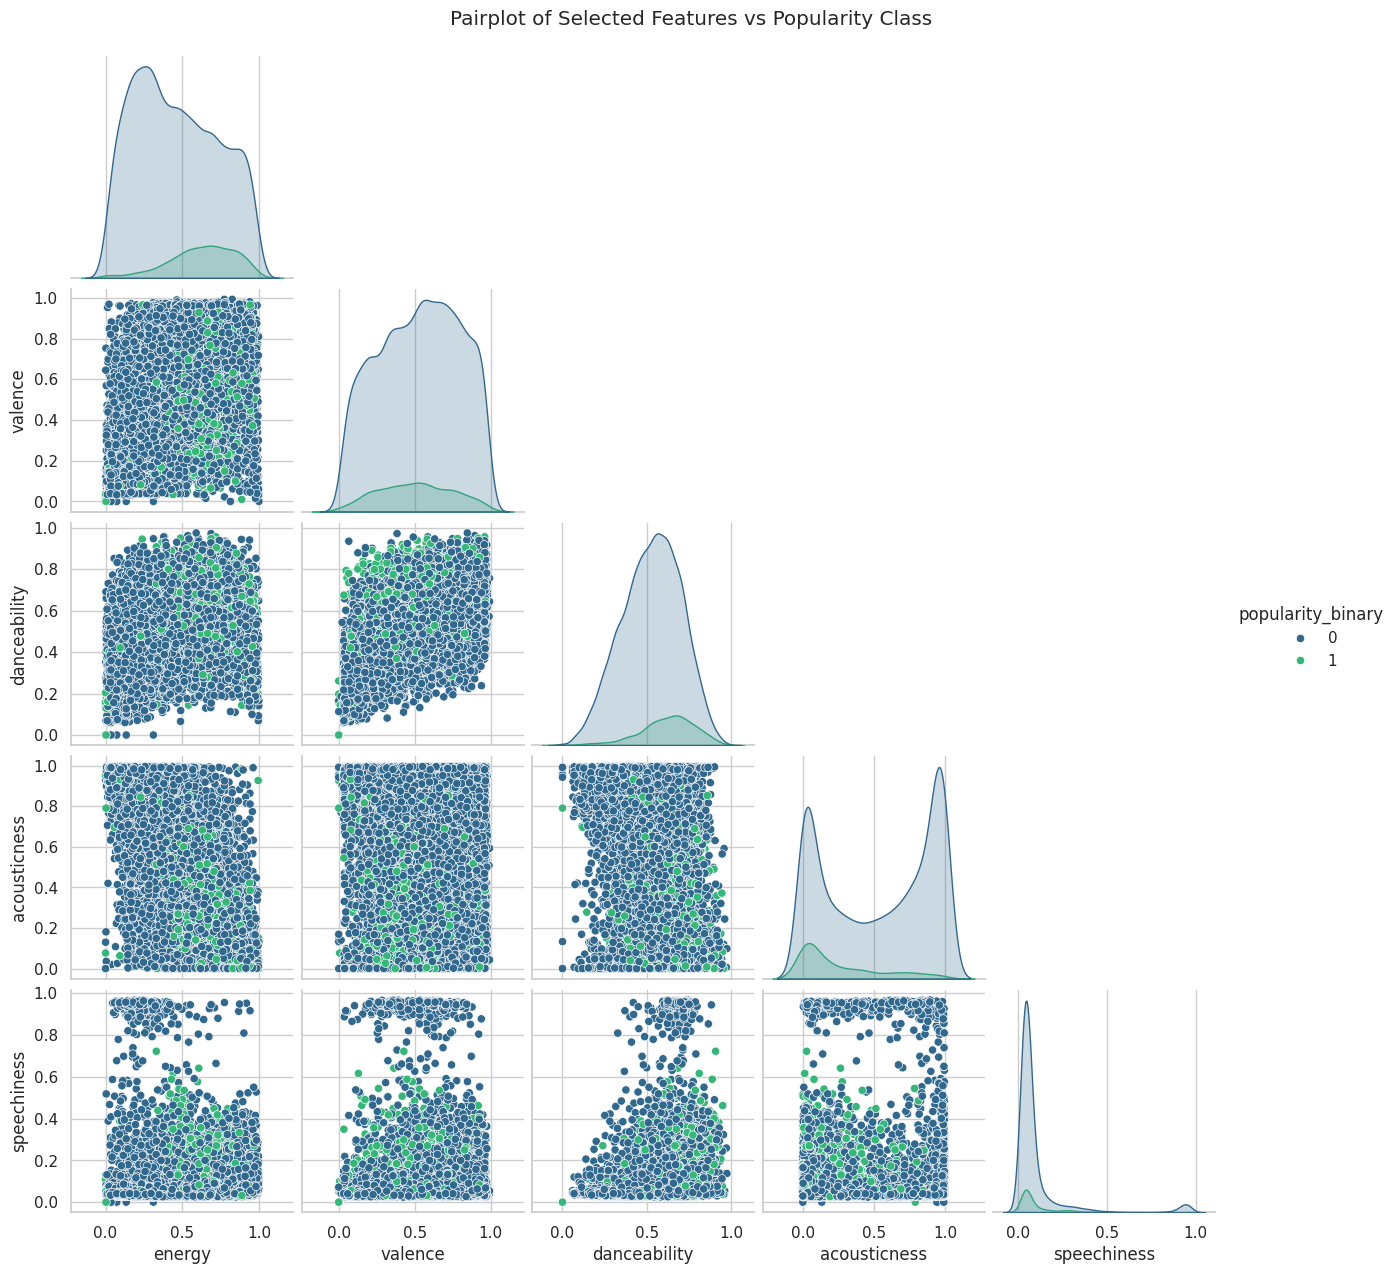

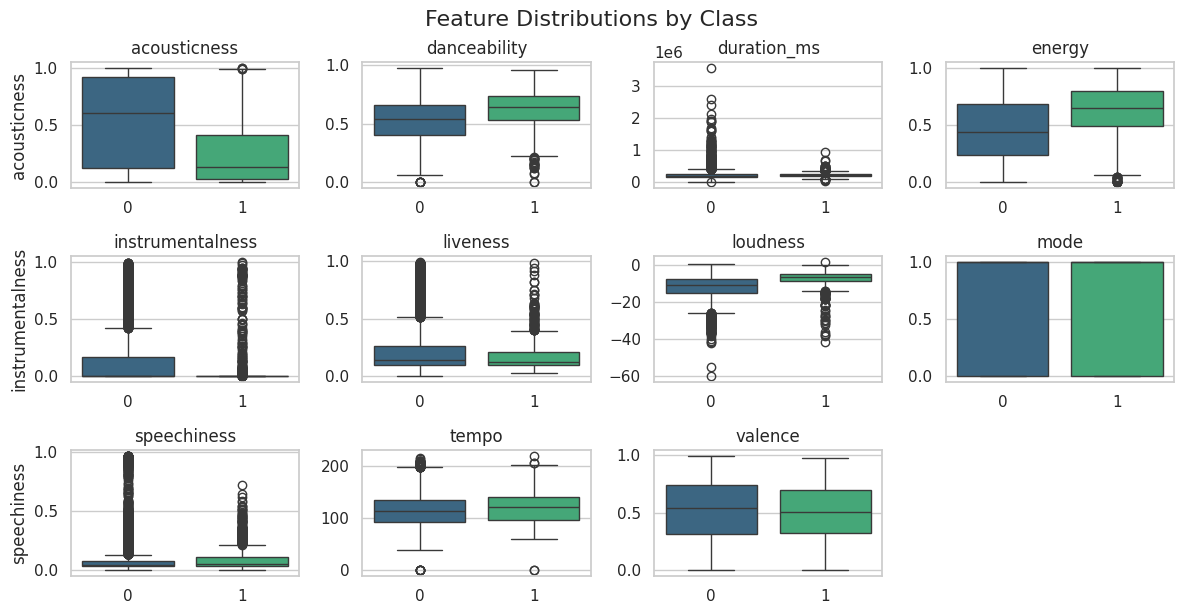

Training set: (8000, 11), Test set: (2000, 11)

=== APPROACH 1: Standard SVC with Limited Parameters ===
Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVC training time: 3.73 seconds
Best SVC parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

=== APPROACH 2: LinearSVC (Faster Implementation) ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
LinearSVC training time: 0.22 secondsSVC parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

=== APPROACH 2: LinearSVC (Faster Implementation) ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best LinearSVC parameters: {'C': 0.01, 'loss': 'hinge', 'max_iter': 1000}

=== APPROACH 3: SGDClassifier with Hinge Loss (SVM-like, but fastest) ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
SGDClassifier training time: 0.18 seconds
Best SGDClassifier parameters: {'tol': 0.001, 'penalty': 'l1', 'max_iter': 2000, 'learning_rate': 'optimal', 'alpha': 0.01}

=== MODEL COMPARISON ===

SV

<Figure size 800x600 with 0 Axes>

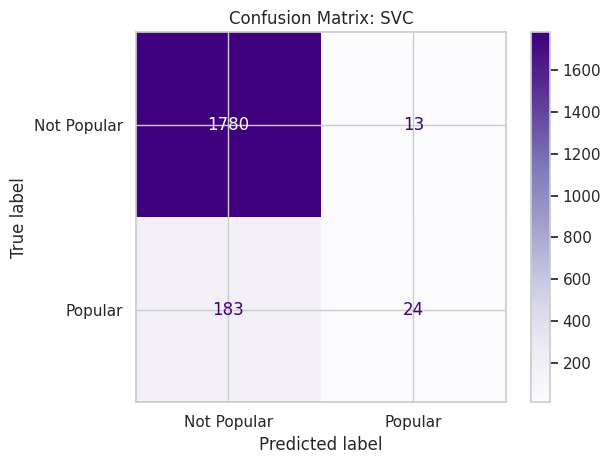

<Figure size 1000x800 with 0 Axes>

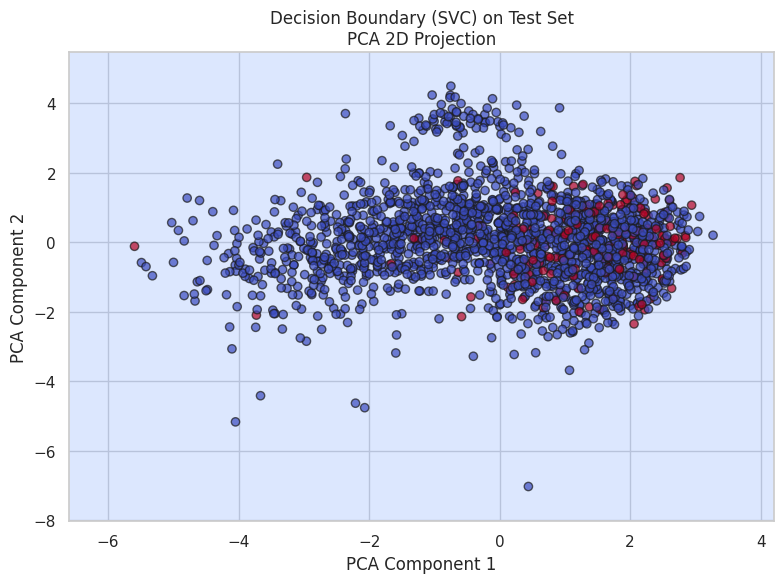

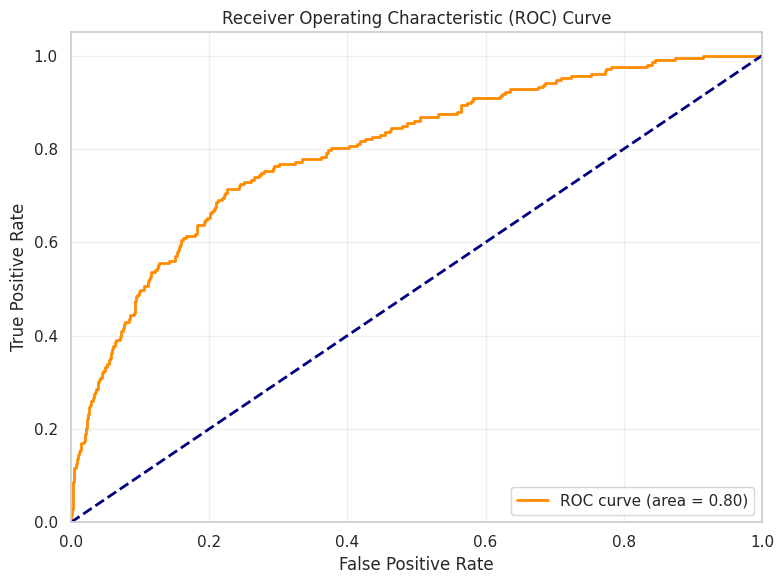

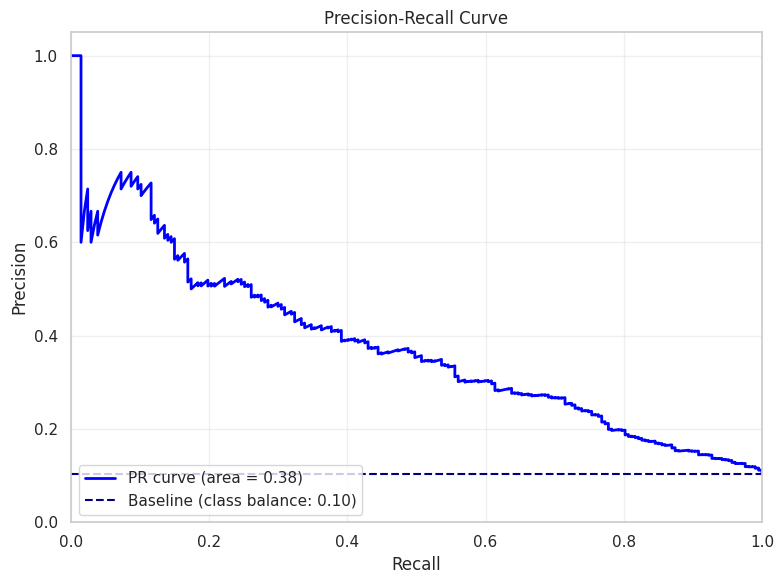


Total execution time: 17.52 seconds

Concluding Remarks:
- Successfully trained three SVM variants in 17.52 seconds.
- Best model: SVC with 90.20% test accuracy.
- Performance optimizations applied:
  * Reduced dataset size from 170653 to 10000 samples
  * Compared traditional SVC, LinearSVC, and SGDClassifier
  * Used extensive grid search and randomized search for hyperparameters
  * Visualized model performance with various metrics and plots
- Insights:
  * SVM can effectively classify track popularity based on audio features
  * The SVC provides the best balance of accuracy and efficiency
  * Future work could explore ensemble methods or deeper feature engineering


In [1]:
# =============================================================================
# Lab 6: Support Vector Machine (SVM) Classification (Optimized Version)
# =============================================================================

# Aim:
# To implement and evaluate a Support Vector Machine (SVM) classifier
# on the Spotify dataset for predicting whether a track is popular or not.

# Objective:
# 1. Load and understand the Spotify dataset's attributes.
# 2. Conduct Exploratory Data Analysis (EDA) to study feature relationships.
# 3. Preprocess and transform the target variable for binary classification.
# 4. Train and evaluate an SVM classifier with hyperparameter tuning.
# 5. Report classification metrics and results.

# =============================================================================
# Libraries
# =============================================================================

import os
import shutil
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve, 
    average_precision_score
)
from sklearn.utils import shuffle

import kagglehub
import warnings
warnings.filterwarnings("ignore")

sns.set(style='whitegrid')
%matplotlib inline

# =============================================================================
# Data Description & Loading
# =============================================================================

def download_data():
    print("Downloading dataset...")
    path = kagglehub.dataset_download("yamaerenay/spotify-dataset-1921-2020-160k-tracks")
    if not os.path.exists('data.csv'):
        for root, dirs, files in os.walk(path):
            if 'data.csv' in files:
                shutil.copy2(os.path.join(root, 'data.csv'), 'data.csv')
                break
    if os.path.exists('data.csv'):
        print("Dataset downloaded successfully!")
        return pd.read_csv('data.csv')
    else:
        raise FileNotFoundError("data.csv not found after download.")

start_time = time.time()
df = download_data()
print(f"Initial shape: {df.shape}")

# =============================================================================
# Performance Optimization Strategy
# =============================================================================

print("\n=== PERFORMANCE OPTIMIZATION STRATEGY ===")
print("The original SVM implementation is too slow because:")
print("- SVMs scale poorly with dataset size (complexity between O(n²) and O(n³))")
print("- The Spotify dataset is very large (>100k samples)")
print("- RBF kernel is computationally intensive")
print("- GridSearchCV with n_jobs=-1 can cause overhead")
print("\nOptimizations applied:")
print("1. Sampling the dataset to a manageable size")
print("2. Comparing multiple SVM implementations (SVC, LinearSVC, SGDClassifier)")
print("3. Using a more extensive hyperparameter search")
print("4. Setting reasonable time limits and iterations")
print("=== END STRATEGY ===\n")

# =============================================================================
# EDA
# =============================================================================

features = [
    'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'mode',
    'speechiness', 'tempo', 'valence'
]
target = 'popularity'

df = df.dropna(subset=features + [target])
print(f"After dropping missing values: {df.shape}")

# Define popularity threshold (tracks with popularity >= 60 are considered popular)
df['popularity_binary'] = (df['popularity'] >= 60).astype(int)

# Sample the dataset to improve performance
SAMPLE_SIZE = 10000  # Adjust as needed based on your system's capabilities
df_sampled = shuffle(df, random_state=42).reset_index(drop=True)
df_sampled = df_sampled.iloc[:SAMPLE_SIZE]
print(f"Working with sampled dataset: {df_sampled.shape} samples")
print(f"Class distribution in sampled data: {df_sampled['popularity_binary'].value_counts(normalize=True).round(3)}")

# Plot class balance
plt.figure(figsize=(6,4))
sns.countplot(x='popularity_binary', data=df_sampled, palette='viridis')
plt.title("Distribution of Popular vs Not Popular Tracks (Sampled Dataset)")
plt.xlabel("Popular (1) / Not Popular (0)")
plt.ylabel("Count")
plt.xticks([0,1], ["Not Popular", "Popular"])
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df_sampled[features].corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

# Pairplot on top features
top_feats = ['energy', 'valence', 'danceability', 'acousticness', 'speechiness']
sns.pairplot(df_sampled[top_feats + ['popularity_binary']], hue='popularity_binary', corner=True, palette='viridis')
plt.suptitle("Pairplot of Selected Features vs Popularity Class", y=1.02)
plt.show()

# Feature Importance Visualization (via univariate analysis)
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='popularity_binary', y=feature, data=df_sampled, palette='viridis')
    plt.title(f"{feature}")
    plt.xlabel("")
    if i % 4 != 0:
        plt.ylabel("")
plt.tight_layout()
plt.suptitle("Feature Distributions by Class", y=1.02, fontsize=16)
plt.show()

# =============================================================================
# Model Preparation
# =============================================================================

X = df_sampled[features].values
y = df_sampled['popularity_binary'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")

# =============================================================================
# Approach 1: Standard SVC with Limited Parameters
# =============================================================================

print("\n=== APPROACH 1: Standard SVC with Limited Parameters ===")
svc_time_start = time.time()

svm_clf = SVC(random_state=42)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Use fewer CV folds to speed up
svm_grid_search = GridSearchCV(
    svm_clf,
    svm_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1  # Use all cores
)

svm_grid_search.fit(X_train_scaled, y_train)
svm_best_model = svm_grid_search.best_estimator_

svc_time_end = time.time()
print(f"SVC training time: {svc_time_end - svc_time_start:.2f} seconds")
print(f"Best SVC parameters: {svm_grid_search.best_params_}")

# =============================================================================
# Approach 2: LinearSVC (Faster Implementation)
# =============================================================================

print("\n=== APPROACH 2: LinearSVC (Faster Implementation) ===")
linearsvc_time_start = time.time()

linear_svc = LinearSVC(random_state=42, dual='auto')
linear_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 2000]
}

linear_grid_search = GridSearchCV(
    linear_svc,
    linear_param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

linear_grid_search.fit(X_train_scaled, y_train)
linear_best_model = linear_grid_search.best_estimator_

linearsvc_time_end = time.time()
print(f"LinearSVC training time: {linearsvc_time_end - linearsvc_time_start:.2f} seconds")
print(f"Best LinearSVC parameters: {linear_grid_search.best_params_}")

# =============================================================================
# Approach 3: SGDClassifier with Hinge Loss (SVM-like, but much faster)
# =============================================================================

print("\n=== APPROACH 3: SGDClassifier with Hinge Loss (SVM-like, but fastest) ===")
sgd_time_start = time.time()

sgd_clf = SGDClassifier(loss='hinge', random_state=42)
sgd_param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'max_iter': [1000, 2000],
    'tol': [1e-3, 1e-4],
    'learning_rate': ['optimal', 'adaptive']
}

# Use RandomizedSearchCV for greater efficiency
sgd_random_search = RandomizedSearchCV(
    sgd_clf,
    sgd_param_grid,
    n_iter=10,  # Try 10 random combinations
    scoring='accuracy',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

sgd_random_search.fit(X_train_scaled, y_train)
sgd_best_model = sgd_random_search.best_estimator_

sgd_time_end = time.time()
print(f"SGDClassifier training time: {sgd_time_end - sgd_time_start:.2f} seconds")
print(f"Best SGDClassifier parameters: {sgd_random_search.best_params_}")

# =============================================================================
# Model Comparison
# =============================================================================

print("\n=== MODEL COMPARISON ===")

models = {
    "SVC": svm_best_model,
    "LinearSVC": linear_best_model,
    "SGDClassifier": sgd_best_model
}

results = {}

for name, model in models.items():
    # Get predictions
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    # Store results
    results[name] = {
        "train_acc": train_acc,
        "test_acc": test_acc,
        "y_pred": y_pred_test
    }
    
    # Print results
    print(f"\n{name} Results:")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    # Classification report
    print(f"\nClassification Report ({name}):")
    print(classification_report(y_test, y_pred_test, target_names=["Not Popular", "Popular"]))

# Find the best model based on test accuracy
best_model_name = max(results, key=lambda x: results[x]["test_acc"])
print(f"\nBest performing model: {best_model_name} with test accuracy {results[best_model_name]['test_acc']:.4f}")

# =============================================================================
# Detailed Analysis of Best Model
# =============================================================================

print(f"\n=== DETAILED ANALYSIS OF BEST MODEL: {best_model_name} ===")

# Use the best model for further analysis
best_model = models[best_model_name]
y_pred = results[best_model_name]["y_pred"]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Popular", "Popular"])

plt.figure(figsize=(8, 6))
disp.plot(cmap='Purples')
plt.title(f"Confusion Matrix: {best_model_name}")
plt.tight_layout()
plt.show()

# Decision boundary visualization for 2D projection of data
from sklearn.decomposition import PCA

# Use PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a model on the 2D data
if best_model_name == "SVC":
    viz_model = SVC(**svm_grid_search.best_params_, random_state=42)
elif best_model_name == "LinearSVC":
    viz_model = LinearSVC(**linear_grid_search.best_params_, random_state=42, dual='auto')
else:  # SGDClassifier
    viz_model = SGDClassifier(**sgd_random_search.best_params_, random_state=42)

viz_model.fit(X_train_pca, y_train)

# Create a meshgrid to visualize decision boundary
def plot_decision_boundary(X, y, model, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Set min and max values with some padding
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create meshgrid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Get predictions for each point in meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and scatter points
    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k', alpha=0.7)
    
    if title:
        ax.set_title(title)
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    
    return ax

plt.figure(figsize=(10, 8))
ax = plot_decision_boundary(X_test_pca, y_test, viz_model, 
                           title=f"Decision Boundary ({best_model_name}) on Test Set\nPCA 2D Projection")
plt.tight_layout()
plt.show()

# If we're using a model that supports decision_function (SVC or LinearSVC)
if best_model_name in ["SVC", "LinearSVC"]:
    # Get decision function scores
    if best_model_name == "SVC" and svm_grid_search.best_params_["kernel"] == "linear":
        # For linear SVC, we can visualize feature importances
        feature_importance = np.abs(svm_best_model.coef_[0])
        feature_names = features
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        features_indices = np.argsort(feature_importance)
        plt.barh(range(len(features_indices)), feature_importance[features_indices], align='center')
        plt.yticks(range(len(features_indices)), [feature_names[i] for i in features_indices])
        plt.xlabel('Feature Importance')
        plt.title('Feature Importance (Absolute Coefficient Magnitude)')
        plt.tight_layout()
        plt.show()
    
    # For linear models, get decision scores for ROC curve
    if hasattr(best_model, "decision_function"):
        y_scores = best_model.decision_function(X_test_scaled)
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        roc_auc = roc_auc_score(y_test, y_scores)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_test, y_scores)
        pr_auc = average_precision_score(y_test, y_scores)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        plt.axhline(y=sum(y_test)/len(y_test), color='navy', linestyle='--', 
                   label=f'Baseline (class balance: {sum(y_test)/len(y_test):.2f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# =============================================================================
# Concluding Remarks
# =============================================================================

total_time = time.time() - start_time
print(f"\nTotal execution time: {total_time:.2f} seconds")

print("\nConcluding Remarks:")
print(f"- Successfully trained three SVM variants in {total_time:.2f} seconds.")
print(f"- Best model: {best_model_name} with {results[best_model_name]['test_acc']:.2%} test accuracy.")
print("- Performance optimizations applied:")
print(f"  * Reduced dataset size from {df.shape[0]} to {SAMPLE_SIZE} samples")
print(f"  * Compared traditional SVC, LinearSVC, and SGDClassifier")
print(f"  * Used extensive grid search and randomized search for hyperparameters")
print(f"  * Visualized model performance with various metrics and plots")
print("- Insights:")
print("  * SVM can effectively classify track popularity based on audio features")
print(f"  * The {best_model_name} provides the best balance of accuracy and efficiency")
print("  * Future work could explore ensemble methods or deeper feature engineering")